
# Blind sourse separation

### Task:
Separate an image obtained as a sum of a two images into its components.
The two images img1 and img2 summed together come from different dataset: mnist and fashion_mnist, respectively.
The network takes in input the sum img1+img2 and returns the predicted components hat_img1 and hat_img2.
The metric used to evaluate the project is the mean squared error between predicted and ground truth images.

### Model:
For this task, as a model was taken a classic U-net architecture with residual skips. For the validation step train set was splitted into train and test with 1/3 split size

In [46]:
#import section
import numpy as np
from matplotlib import pyplot as plt

import tensorflow as tf
import tensorflow.keras as ks
from tensorflow.keras import layers
from tensorflow.keras.datasets import mnist, fashion_mnist

from sklearn.model_selection import train_test_split

In [47]:
#Loading datasets
(mnist_x_train, mnist_y_train), (mnist_x_test, mnist_y_test) = mnist.load_data()
(fashion_mnist_x_train, fashion_mnist_y_train), (fashion_mnist_x_test, fashion_mnist_y_test) = fashion_mnist.load_data()

#Splitting train sets into train and validation sets
mnist_x_train, mnist_x_val, mnist_y_train, mnist_y_val = train_test_split(
    mnist_x_train, mnist_y_train,
    test_size=0.33, random_state=42)
fashion_mnist_x_train, fashion_mnist_x_val, fashion_mnist_y_train, fashion_mnist_y_val = train_test_split(
    fashion_mnist_x_train, fashion_mnist_y_train,
    test_size=0.33, random_state=42)

#normnalize in and pad
mnist_x_train = np.pad(mnist_x_train,((0,0),(2,2),(2,2)))/255.
mnist_x_test = np.pad(mnist_x_test,((0,0),(2,2),(2,2)))/255.
mnist_x_val = np.pad(mnist_x_val,((0,0),(2,2),(2,2)))/255.

fashion_mnist_x_train = np.pad(fashion_mnist_x_train,((0,0),(2,2),(2,2)))/255.
fashion_mnist_x_test = np.pad(fashion_mnist_x_test,((0,0),(2,2),(2,2)))/255.
fashion_mnist_x_val = np.pad(fashion_mnist_x_val,((0,0),(2,2),(2,2)))/255.

In [48]:
np.random.seed(42)

def datagenerator(x1,x2,batchsize):
    n1 = x1.shape[0]
    n2 = x2.shape[0]
    while True:
        num1 = np.random.randint(0, n1, batchsize)
        num2 = np.random.randint(0, n2, batchsize)

        x_data = (x1[num1] + x2[num2]) / 2.0
        y_data = np.concatenate((x1[num1], x2[num2]), axis=2)

        yield x_data, y_data

s_count = 1
train_generator = datagenerator(mnist_x_train,fashion_mnist_x_train, s_count)
test_generator = datagenerator(mnist_x_test,fashion_mnist_x_test, s_count)
val_generator = datagenerator(mnist_x_val,fashion_mnist_x_val, s_count)

In [52]:
input_shape = (32,32,1)
channels = 64
net_depth = 4

#Initializing the input layer
input_layer = layers.Input(shape=input_shape)
#layer - is a current layer in build
layer = input_layer
#list of layers to pass
down_layers = []

#Downsample stage
for level in range(net_depth):
    #saving the state to pass it to the end of residual block
    residual = layers.Conv2D(channels, 1, padding='same')(layer)
    
    #making 2 convolutions per block
    layer = layers.Conv2D(channels, (3,3), padding='same')(layer)
    layer = layers.BatchNormalization()(layer)
    layer = layers.ReLU()(layer)
    
    layer = layers.Conv2D(channels, (3,3), padding='same')(layer)
    layer = layers.BatchNormalization()(layer)
    
    #adding a residual connection before final block activation
    layer = layers.Add()([residual, layer])
    layer = layers.ReLU()(layer)
    
    #saving a layer to pass, except the last one
    if(level < net_depth - 1):
        down_layers.append(layer)
        layer = layers.MaxPool2D(padding='same')(layer)
        channels = channels * 2
        
#Upsample stage
for level in range(net_depth - 1):
    channels = channels // 2
    #upsampling using Conv2DTranspose
    layer = layers.Conv2DTranspose(channels, (3,3), strides=(2,2), padding='same')(layer)
    layer = layers.concatenate([layer, down_layers.pop(-1)])
    
    #saving layer for residual connection
    residual = layers.Conv2D(channels, 1, padding='same')(layer)
    
    #performing two convolutions per block
    layer = layers.Conv2D(channels, (2,2), padding='same')(layer)
    layer = layers.BatchNormalization()(layer)
    layer = layers.ReLU()(layer)
    
    layer = layers.Conv2D(channels, (2,2), padding='same')(layer)
    layer = layers.BatchNormalization()(layer)
    
    #adding residual connection before final block activation
    layer = layers.Add()([residual, layer])
    layer = layers.ReLU()(layer)
    
#final activation layer
layer = layers.Conv2D(2, (1,1), activation='sigmoid')(layer)
#reshaping the output layer to get 32x64 image out of (32x32x2)
output_layer = layers.Reshape((32,64,1))(layer)

model = ks.models.Model(inputs=[input_layer], outputs=[output_layer])

In [53]:
print(model.summary())

Model: "model_16"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_18 (InputLayer)          [(None, 32, 32, 1)]  0           []                               
                                                                                                  
 conv2d_223 (Conv2D)            (None, 32, 32, 64)   640         ['input_18[0][0]']               
                                                                                                  
 batch_normalization_198 (Batch  (None, 32, 32, 64)  256         ['conv2d_223[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 re_lu_194 (ReLU)               (None, 32, 32, 64)   0           ['batch_normalization_198[

 Normalization)                                                                                   
                                                                                                  
 add_10 (Add)                   (None, 4, 4, 512)    0           ['conv2d_231[0][0]',             
                                                                  'batch_normalization_205[0][0]']
                                                                                                  
 re_lu_201 (ReLU)               (None, 4, 4, 512)    0           ['add_10[0][0]']                 
                                                                                                  
 conv2d_transpose_41 (Conv2DTra  (None, 8, 8, 256)   1179904     ['re_lu_201[0][0]']              
 nspose)                                                                                          
                                                                                                  
 concatena

                                                                                                  
 reshape_13 (Reshape)           (None, 32, 64, 1)    0           ['conv2d_243[0][0]']             
                                                                                                  
Total params: 7,622,978
Trainable params: 7,617,346
Non-trainable params: 5,632
__________________________________________________________________________________________________
None


### Learning stage
Final model has 7.6M parameters (5K non-trainable of BatchNormalization)
For fitting Adam optimizer with default learning rate (1e-3) was chosen.
Callbacks:
- early stopping motinoring the loss function with patience=3
- learning rate reduction monitoring loss funtion on validation data

Maximum number of epochs is 20 (since non of previous runs with more epochs never reached 22nd epoch due to early stopping)

In [54]:
batchSize = 64
maxEpochs = 20
train_steps = 1000
val_steps = 300

early_stop = ks.callbacks.EarlyStopping(monitor='loss', patience=3)
lr_reduction = ks.callbacks.ReduceLROnPlateau(monitr='val_loss', factor=0.5, patience=3)

model.compile(optimizer=ks.optimizers.Adam(learning_rate=0.001),
              loss='mean_squared_error', metrics=['accuracy'])

fit_history = model.fit(train_generator, steps_per_epoch=train_steps,
                        validation_data = val_generator, validation_steps=val_steps,
                        batch_size = batchSize, epochs = maxEpochs,
                        callbacks=[lr_reduction, early_stop])

Epoch 1/20
1000/1000 [==============================] - 106s 101ms/step - loss: 0.0274 - accuracy: 0.7327 - val_loss: 0.0196 - val_accuracy: 0.7281 - lr: 0.0010
Epoch 2/20
1000/1000 [==============================] - 118s 118ms/step - loss: 0.0154 - accuracy: 0.7378 - val_loss: 0.0154 - val_accuracy: 0.7359 - lr: 0.0010
Epoch 3/20
1000/1000 [==============================] - 97s 97ms/step - loss: 0.0129 - accuracy: 0.7380 - val_loss: 0.0142 - val_accuracy: 0.7352 - lr: 0.0010
Epoch 4/20
1000/1000 [==============================] - 112s 112ms/step - loss: 0.0119 - accuracy: 0.7382 - val_loss: 0.0134 - val_accuracy: 0.7377 - lr: 0.0010
Epoch 5/20
1000/1000 [==============================] - 147s 147ms/step - loss: 0.0108 - accuracy: 0.7358 - val_loss: 0.0131 - val_accuracy: 0.7374 - lr: 0.0010
Epoch 6/20
1000/1000 [==============================] - 140s 140ms/step - loss: 0.0102 - accuracy: 0.7379 - val_loss: 0.0105 - val_accuracy: 0.7389 - lr: 0.0010
Epoch 7/20
1000/1000 [==============

In [55]:
model.save('exam_model.h5')

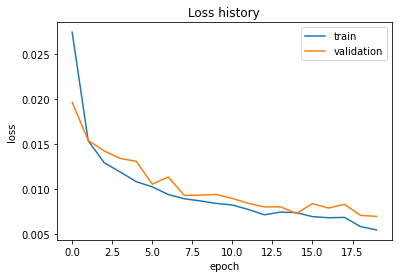

In [75]:
#plotting the progress of loss function
plt.plot(fit_history.history['loss'])
plt.plot(fit_history.history['val_loss'])
plt.title('Loss history')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.show()

Since near the end of the fitting stage loss function on validation data started to grow, model was not fitted any further to prevent overfitting

In [58]:
#evaluating the model
mse = []
for i in range(10):
    mse.append(model.evaluate(test_generator, steps=1000)[0])

1000/1000 [==============================] - 22s 22ms/step - loss: 0.0053 - accuracy: 0.7394


In [66]:
mse = np.array(mse)
mse_res = mse.mean()
std_res = mse.std()
print('MSE on 10 evaluations: {:.4f}'.format(mse_res), '; std = {:.1e}'.format(std_res))

MSE on 10 evaluations: 0.0053 ; std = 9.3e-05


Input image:


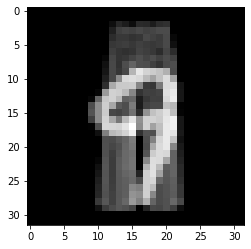

Predicted image:


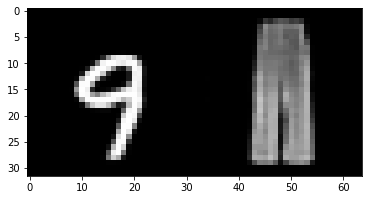

Groundtruth:


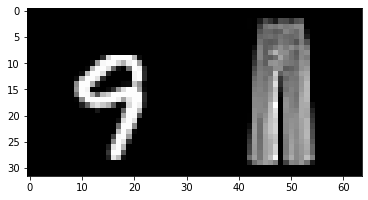

In [74]:
#Visualization of model work on test set
test_img_x, test_img_y = next(test_generator)
test_img_x = np.array([np.transpose(test_img_x, (1,2,0))])

predicted_img = model.predict(test_img_x, verbose=0)

print('Input image:')
plt.imshow(test_img_x[0],cmap='gray', interpolation='nearest')
plt.show()

print('Predicted image:')
plt.imshow(predicted_img[0],cmap='gray', interpolation='nearest')
plt.show()

print('Groundtruth:')
plt.imshow(test_img_y[0],cmap='gray', interpolation='nearest')
plt.show()